# The Dataset Exploration Notebook

The code is mainly taken from the sources below:

- https://github.com/NielsRogge/Transformers-Tutorials

- https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

- https://huggingface.co/docs/transformers/en/model_doc/audio-spectrogram-transformer

In [1]:
from torchaudio.datasets import SPEECHCOMMANDS

import torch
import sys
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
train_set = SPEECHCOMMANDS(root="./dataset", download=True, subset="training")
test_set = SPEECHCOMMANDS(root="./dataset", download=True, subset="testing")
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


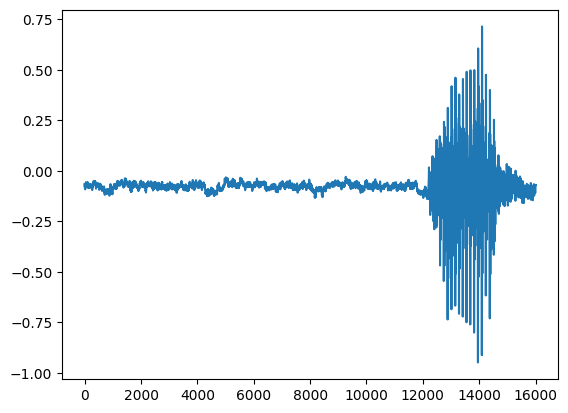

In [3]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())

In [4]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

print(len(labels))
print(f"Type of labels: {type(labels)}")
print(f"Labels: {labels}")

35
Type of labels: <class 'list'>
Labels: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


# Create Sample Auido Output

In [5]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [6]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

In [7]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "zero"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

zero --> tensor(34) --> zero


In [8]:
from transformers import ASTForAudioClassification, AutoProcessor
processor = AutoProcessor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", attn_implementation="sdpa", torch_dtype=torch.float32)

# Copy the model and remove the classifier to get the embeddings
from copy import deepcopy
model2 = deepcopy(model)
model2.classifier = torch.nn.Identity()

# Print the possible output classes
print(model.config.id2label.values())

/Users/ilerisoy/anaconda3/envs/protonet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


dict_values(['Speech', 'Male speech, man speaking', 'Female speech, woman speaking', 'Child speech, kid speaking', 'Conversation', 'Narration, monologue', 'Babbling', 'Speech synthesizer', 'Shout', 'Bellow', 'Whoop', 'Yell', 'Battle cry', 'Children shouting', 'Screaming', 'Whispering', 'Laughter', 'Baby laughter', 'Giggle', 'Snicker', 'Belly laugh', 'Chuckle, chortle', 'Crying, sobbing', 'Baby cry, infant cry', 'Whimper', 'Wail, moan', 'Sigh', 'Singing', 'Choir', 'Yodeling', 'Chant', 'Mantra', 'Male singing', 'Female singing', 'Child singing', 'Synthetic singing', 'Rapping', 'Humming', 'Groan', 'Grunt', 'Whistling', 'Breathing', 'Wheeze', 'Snoring', 'Gasp', 'Pant', 'Snort', 'Cough', 'Throat clearing', 'Sneeze', 'Sniff', 'Run', 'Shuffle', 'Walk, footsteps', 'Chewing, mastication', 'Biting', 'Gargling', 'Stomach rumble', 'Burping, eructation', 'Hiccup', 'Fart', 'Hands', 'Finger snapping', 'Clapping', 'Heart sounds, heartbeat', 'Heart murmur', 'Cheering', 'Applause', 'Chatter', 'Crowd', '

In [9]:
# Get a sample from the dataset
waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

# Preprocess the audio
inputs = processor(waveform[0], sampling_rate=sample_rate, return_tensors="pt")
print(inputs.keys())

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

# Analyze the output
print(outputs.logits.shape)
predicted_class_idx = outputs.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

dict_keys(['input_values'])
torch.Size([1, 527])
Predicted class: Speech


In [10]:
# Run inference with the modified model
with torch.no_grad():
    outputs = model2(**inputs)

# Analyze the output
print(outputs.logits.shape)
predicted_class_idx = outputs.logits.argmax(-1).item()
print("Predicted class:", model2.config.id2label[predicted_class_idx])

torch.Size([1, 768])
Predicted class: Foghorn
